<a href="https://colab.research.google.com/github/vahapayzet/drybean/blob/main/drybean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Vahap Ayzet
# 234329054
# Üsküdar Üniversitesi - Yapay Zeka Mühendisliği YL

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, RocCurveDisplay

import warnings
warnings.filterwarnings("ignore")


# Veri Setini Yükleme (UCI'den İndirip Kaydetme)

In [ ]:
import pandas as pd

# Excel dosyasını oku
df = pd.read_excel("/content/drive/MyDrive/dry/DryBeanDataset/Dry_Bean_Dataset.xlsx")

# İlk birkaç satıra göz atalım
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


# AŞAMA 3: Eksik Verilerin Eklenmesi

%5 → Area, Perimeter

%35 → Eccentricity

In [ ]:
import numpy as np

# Kopya veri seti üzerinden çalışalım
df_missing = df.copy()

# %5 eksik veri eklenecek sütunlar
for col in ['Area', 'Perimeter']:
    df_missing.loc[df_missing.sample(frac=0.05, random_state=42).index, col] = np.nan

# %35 eksik veri eklenecek sütun
df_missing.loc[df_missing.sample(frac=0.35, random_state=42).index, 'Eccentricity'] = np.nan

# Eksik değer sayısını kontrol et
df_missing.isnull().sum()


,0
Area,681
Perimeter,681
MajorAxisLength,0
MinorAxisLength,0
AspectRation,0
Eccentricity,4764
ConvexArea,0
EquivDiameter,0
Extent,0
Solidity,0


# AŞAMA 4: Eksik Verilerin İşlenmesi

1. Ortalama ile Doldurma (Area ve Perimeter)

In [ ]:
df_missing['Area'].fillna(df_missing['Area'].mean(), inplace=True)
df_missing['Perimeter'].fillna(df_missing['Perimeter'].mean(), inplace=True)


2. Eccentricity İçin Satır Silme

In [ ]:
df_missing.dropna(subset=['Eccentricity'], inplace=True)


Kontrol Edelim

In [ ]:
df_missing.isnull().sum()

,0
Area,0
Perimeter,0
MajorAxisLength,0
MinorAxisLength,0
AspectRation,0
Eccentricity,0
ConvexArea,0
EquivDiameter,0
Extent,0
Solidity,0


# AŞAMA 5: Aykırı Değer Tespiti ve İşleme (IQR Yöntemi)

IQR Yöntemi ile Aykırı Değer Bulma Fonksiyonu

In [ ]:
def detect_outliers_iqr(df, features):
    outlier_indices = []

    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices.extend(outliers)

    return list(set(outlier_indices))  # tekrar edenleri kaldır

# Sınıf sütununu dışarda bırak
numerical_cols = df_missing.drop(columns=['Class']).columns

# Aykırı değerleri bul
outliers = detect_outliers_iqr(df_missing, numerical_cols)

print(f"Aykırı gözlem sayısı: {len(outliers)}")


Aykırı gözlem sayısı: 1934


Aykırı değerleri silme;

In [ ]:
df_cleaned = df_missing.drop(index=outliers).reset_index(drop=True)


Kontrol için Histogram (Opsiyonel Görselleştirme)

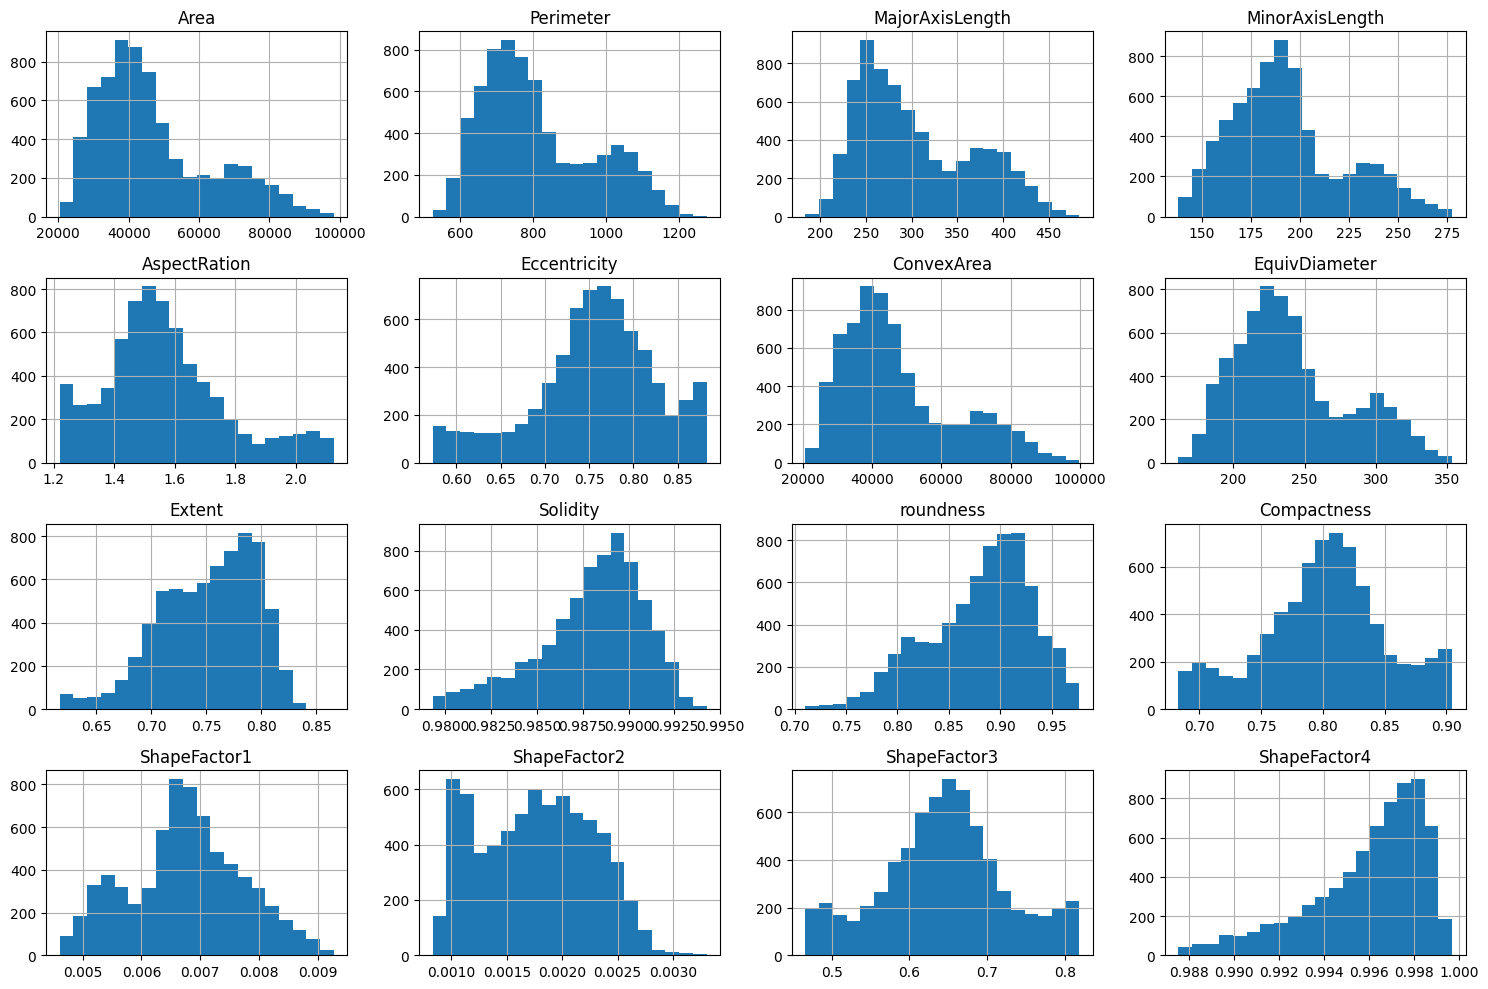

In [ ]:
import matplotlib.pyplot as plt
df_cleaned.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()


# AŞAMA 6: Özellik Ölçekleme (Feature Scaling)

StandardScaler → ortalamayı 0, standart sapmayı 1 yapar (Z-score standardizasyonu)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Sınıf etiketini ayrı tut
X = df_cleaned.drop("Class", axis=1)
y = df_cleaned["Class"]

# StandardScaler uygula
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ölçeklenmiş veriyi DataFrame'e çevir
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Kontrol
X_scaled_df.describe().T


,count,mean,std,min,25%,50%,75%,max
Area,6913.0,-1.315630e-16,1.000072,-1.645583,-0.726541,-0.267855,0.518006,3.165621
Perimeter,6913.0,1.973444e-16,1.000072,-1.869728,-0.759309,-0.245160,0.721244,3.027785
MajorAxisLength,6913.0,2.960166e-16,1.000072,-1.919052,-0.806722,-0.270400,0.826450,2.860961
MinorAxisLength,6913.0,1.315630e-16,1.000072,-1.905748,-0.712230,-0.141889,0.471618,2.914840
AspectRation,6913.0,2.795713e-16,1.000072,-1.738796,-0.643000,-0.144194,0.503509,2.752093
Eccentricity,6913.0,-1.307407e-15,1.000072,-2.620781,-0.508089,0.081465,0.662160,1.825096
ConvexArea,6913.0,-1.315630e-16,1.000072,-1.639650,-0.727169,-0.270137,0.515066,3.178588
EquivDiameter,6913.0,4.604703e-16,1.000072,-1.981594,-0.727169,-0.202296,0.600194,2.777751
Extent,6913.0,1.564366e-15,1.000072,-3.087041,-0.728810,0.136340,0.803404,2.614405
Solidity,6913.0,1.465282e-14,1.000072,-3.003849,-0.533061,0.170542,0.702383,2.171499


# AŞAMA 7: Kategorik Verilerin Kodlanması (Label Encoding)

Label Encoding (Sınıfları Sayıya Çevirme)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Etiketleyici tanımla
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Dönüştürülmüş sınıflara bakalım
class_labels = dict(zip(le.classes_, le.transform(le.classes_)))
print("Sınıf Kodları:", class_labels)


Sınıf Kodları: {'BARBUNYA': np.int64(0), 'CALI': np.int64(1), 'DERMASON': np.int64(2), 'HOROZ': np.int64(3), 'SEKER': np.int64(4), 'SIRA': np.int64(5)}


# AŞAMA 8: PCA ile Boyut İndirgeme

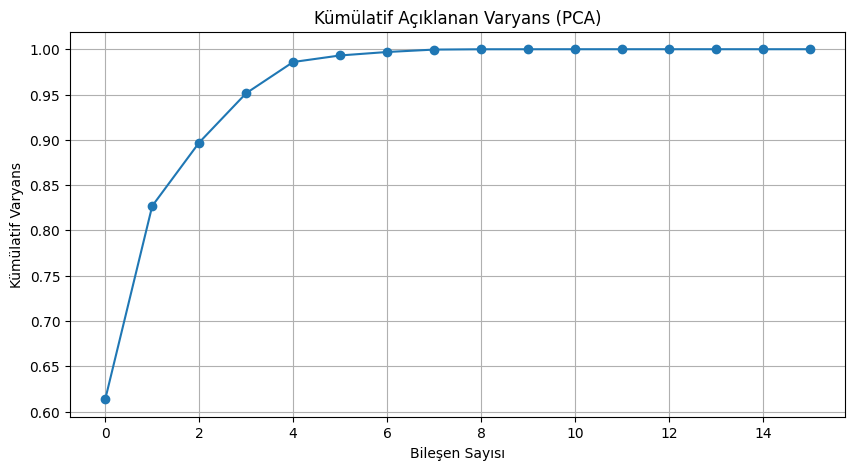

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA modelini eğit (tüm bileşenleri tut)
pca = PCA()
X_pca = pca.fit_transform(X_scaled_df)

# Açıklanan varyans oranları
explained_var = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_var), marker='o')
plt.title("Kümülatif Açıklanan Varyans (PCA)")
plt.xlabel("Bileşen Sayısı")
plt.ylabel("Kümülatif Varyans")
plt.grid(True)
plt.show()


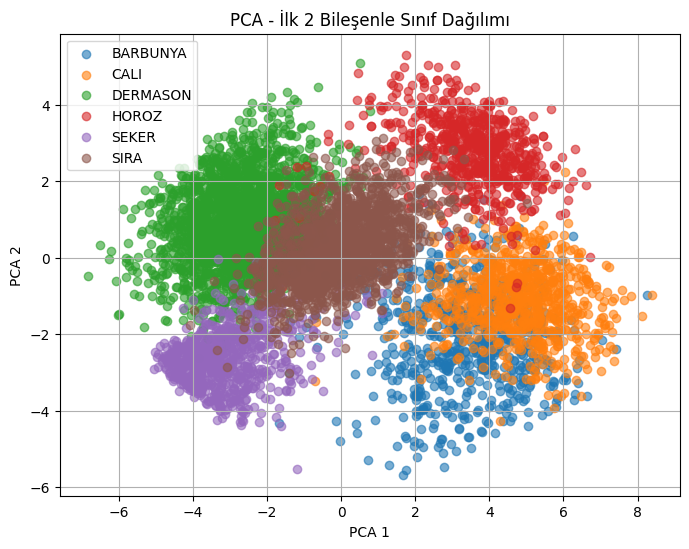

In [ ]:
pca_2 = PCA(n_components=2)
X_pca_2d = pca_2.fit_transform(X_scaled_df)

# Görselleştirme
plt.figure(figsize=(8, 6))
for class_value in np.unique(y_encoded):
    plt.scatter(X_pca_2d[y_encoded == class_value, 0],
                X_pca_2d[y_encoded == class_value, 1],
                label=le.inverse_transform([class_value])[0], alpha=0.6)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA - İlk 2 Bileşenle Sınıf Dağılımı")
plt.legend()
plt.grid(True)
plt.show()


# AŞAMA 9: LDA ile Boyut İndirgeme

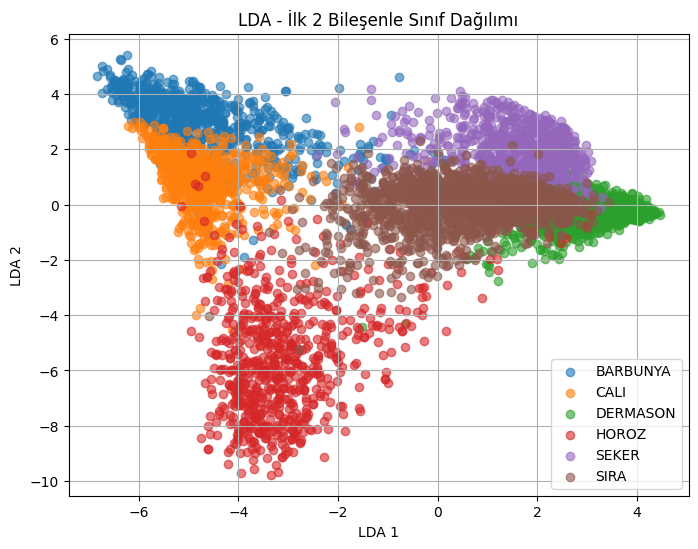

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA modeli, n_components=2 seçildi çünkü 2D çizim yapacağız
lda = LDA(n_components=2)
X_lda_2d = lda.fit_transform(X_scaled_df, y_encoded)

# Görselleştirme
plt.figure(figsize=(8, 6))
for class_value in np.unique(y_encoded):
    plt.scatter(X_lda_2d[y_encoded == class_value, 0],
                X_lda_2d[y_encoded == class_value, 1],
                label=le.inverse_transform([class_value])[0], alpha=0.6)

plt.xlabel("LDA 1")
plt.ylabel("LDA 2")
plt.title("LDA - İlk 2 Bileşenle Sınıf Dağılımı")
plt.legend()
plt.grid(True)
plt.show()


# AŞAMA 10: Modelleme – Nested Cross-Validation

Nested Cross-Validation – Temel Yapı

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def nested_cv(X, y, model, param_grid, model_name="Model", outer_splits=5, inner_splits=3):
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=42)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=42)

    scores = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": []
    }

    for train_ix, test_ix in outer_cv.split(X, y):
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]

        # Hiperparametre ayarı
        grid = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            cv=inner_cv,
                            scoring='accuracy',
                            n_jobs=-1)
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)

        scores["accuracy"].append(accuracy_score(y_test, y_pred))
        scores["precision"].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
        scores["recall"].append(recall_score(y_test, y_pred, average='macro', zero_division=0))
        scores["f1"].append(f1_score(y_test, y_pred, average='macro', zero_division=0))

    # Ortalama ve Standart Sapmalar
    results = {metric: (np.mean(vals), np.std(vals)) for metric, vals in scores.items()}

    print(f"--- {model_name} ---")
    for metric, (mean, std) in results.items():
        print(f"{metric.capitalize()}: {mean:.4f} ± {std:.4f}")

    return results


## MODEL 1: Logistic Regression (Ham Veri Üzerinden)

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, solver='liblinear')  # küçük veri setleri için uygundur

param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10],     # düzenleme parametresi
    'penalty': ['l1', 'l2']      # L1 = Lasso, L2 = Ridge
}


In [ ]:
# X_scaled_df → DataFrame, numpy dizisine çevirelim
X_base = X_scaled_df.to_numpy()
y_base = y_encoded

logreg_results_base = nested_cv(X_base, y_base, log_reg, param_grid_logreg, model_name="Logistic Regression (Ham Veri)")


--- Logistic Regression (Ham Veri) ---
Accuracy: 0.9121 ± 0.0130
Precision: 0.9213 ± 0.0123
Recall: 0.9159 ± 0.0099
F1: 0.9181 ± 0.0110


Bu, veri ön işleme adımlarının gerçekten iyi yapıldığını ve Logistic Regression'ın bu veri setine uygun olduğunu gösteriyor.



## PCA Verisi ile Logistic Regression

In [ ]:
# İlk 4 bileşeni al
X_pca_4 = X_pca[:, :4]

logreg_results_pca = nested_cv(X_pca_4, y_base, log_reg, param_grid_logreg, model_name="Logistic Regression (PCA Veri)")


--- Logistic Regression (PCA Veri) ---
Accuracy: 0.8694 ± 0.0119
Precision: 0.8666 ± 0.0111
Recall: 0.8496 ± 0.0128
F1: 0.8570 ± 0.0118


PCA ile boyut indirgeme, modelin genel başarısını biraz düşürmüş (yaklaşık %4–5 civarı).

Bunun nedeni, PCA’nın sınıfları doğrudan ayırmayı değil, varyansı maksimize etmeyi amaçlaması.

Yani PCA → bilgi korunur ama sınıf ayrımı zayıflayabilir.

## LDA Verisi ile Logistic Regression

In [ ]:
logreg_results_lda = nested_cv(X_lda_2d, y_base, log_reg, param_grid_logreg, model_name="Logistic Regression (LDA Veri)")


--- Logistic Regression (LDA Veri) ---
Accuracy: 0.8851 ± 0.0088
Precision: 0.9006 ± 0.0070
Recall: 0.8746 ± 0.0083
F1: 0.8859 ± 0.0075


Temsil	Accuracy	F1 Score

Ham	  91.2%  	91.8%

PCA	  86.9%	  85.7%

LDA	  88.5%	  88.6%

🧠 Sonuç: Ham veri en iyi sonucu veriyor, ama LDA da çok yakın ve daha az boyutta çalışıyor (2D!). Bu özellikle hız önemliyse avantaj olabilir.

# MODEL 2: Decision Tree Classifier


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(random_state=42)

param_grid_dtree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}


In [ ]:
dtree_results_base = nested_cv(X_base, y_base, dtree, param_grid_dtree, model_name="Decision Tree (Ham Veri)")


--- Decision Tree (Ham Veri) ---
Accuracy: 0.8844 ± 0.0066
Precision: 0.8910 ± 0.0058
Recall: 0.8820 ± 0.0081
F1: 0.8851 ± 0.0060


## PCA Temsili ile Decision Tree

In [ ]:
dtree_results_pca = nested_cv(X_pca_4, y_base, dtree, param_grid_dtree, model_name="Decision Tree (PCA Veri)")


--- Decision Tree (PCA Veri) ---
Accuracy: 0.8590 ± 0.0067
Precision: 0.8538 ± 0.0073
Recall: 0.8497 ± 0.0098
F1: 0.8506 ± 0.0079


 PCA ile veri boyutunu azaltmamız modeli biraz zayıflatmış ama hâlâ tutarlı.

## LDA Temsili ile Decision Tree

In [ ]:
dtree_results_lda = nested_cv(X_lda_2d, y_base, dtree, param_grid_dtree, model_name="Decision Tree (LDA Veri)")


--- Decision Tree (LDA Veri) ---
Accuracy: 0.8843 ± 0.0103
Precision: 0.8904 ± 0.0101
Recall: 0.8772 ± 0.0115
F1: 0.8829 ± 0.0105


Temsil	Accuracy	F1 Score

Ham	88.4%	88.5%

PCA	85.9%	85.1%

LDA	88.4%	88.3%

🔎 Yorum: LDA, daha düşük boyutta çalışmasına rağmen ham veri kadar iyi performans veriyor. PCA ise biraz zayıf kalıyor.

# MODEL 3: Random Forest Classifier (Ham Veri Üzerinden)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}


## Nested CV – Random Forest (Ham Veri):

In [ ]:
rf_results_base = nested_cv(X_base, y_base, rf, param_grid_rf, model_name="Random Forest (Ham Veri)")


--- Random Forest (Ham Veri) ---
Accuracy: 0.9102 ± 0.0108
Precision: 0.9189 ± 0.0121
Recall: 0.9109 ± 0.0084
F1: 0.9144 ± 0.0100


Random Forest, ham veriyle neredeyse Logistic Regression kadar güçlü bir performans göstermiş.

Ensemble yöntemi olan Random Forest’ın, tek ağaçtan (Decision Tree) daha istikrarlı ve güçlü sonuç verdiği görülüyor.

## PCA Temsili ile Random Forest

In [ ]:
rf_results_pca = nested_cv(X_pca_4, y_base, rf, param_grid_rf, model_name="Random Forest (PCA Veri)")


--- Random Forest (PCA Veri) ---
Accuracy: 0.8831 ± 0.0086
Precision: 0.8802 ± 0.0067
Recall: 0.8713 ± 0.0073
F1: 0.8748 ± 0.0068


PCA ile boyutu küçültmemize rağmen Random Forest yine güçlü sonuçlar veriyor.

PCA boyut indirgemesiyle biraz bilgi kaybı yaşanmış ama model hâlâ çok güçlü. Bu da Random Forest’ın robust (dayanıklı) yapısını gösteriyor.

## LDA Temsili ile Random Forest

In [ ]:
rf_results_lda = nested_cv(X_lda_2d, y_base, rf, param_grid_rf, model_name="Random Forest (LDA Veri)")


--- Random Forest (LDA Veri) ---
Accuracy: 0.8973 ± 0.0090
Precision: 0.9034 ± 0.0095
Recall: 0.8957 ± 0.0087
F1: 0.8990 ± 0.0087


LDA temsili ile Random Forest, çok dengeli ve güçlü bir performans sergilemiş.

**Kısa Kıyaslama (Random Forest için):**

Temsil	Accuracy	F1 Score

Ham	91.0%	91.4%

PCA	88.3%	87.5%

LDA	89.7%	89.9%

Yorum: LDA temsili, PCA’dan çok daha iyi sonuçlar veriyor ve ham veriye oldukça yakın.

Bu da LDA’nın düşük boyutlu ama anlamlı bir temsil sunduğunu yeniden gösteriyor.

# MODEL 4: XGBoost Classifier (Ham Veri Üzerinden)

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}


## Nested CV – XGBoost (Ham Veri)

In [ ]:
xgb_results_base = nested_cv(X_base, y_base, xgb, param_grid_xgb, model_name="XGBoost (Ham Veri)")


--- XGBoost (Ham Veri) ---
Accuracy: 0.9142 ± 0.0104
Precision: 0.9254 ± 0.0128
Recall: 0.9168 ± 0.0097
F1: 0.9206 ± 0.0109


XGBoost, şimdiye kadar test ettiğimiz modeller arasında en yüksek başarıyı gösterdi!

XGBoost’un karmaşık veri yapılarıyla çok iyi başa çıkabildiğini bir kez daha görüyoruz. Hem yüksek doğruluk hem de düşük sapma var.

## PCA Temsili ile XGBoost

In [ ]:
xgb_results_pca = nested_cv(X_pca_4, y_base, xgb, param_grid_xgb, model_name="XGBoost (PCA Veri)")


--- XGBoost (PCA Veri) ---
Accuracy: 0.8828 ± 0.0069
Precision: 0.8805 ± 0.0049
Recall: 0.8707 ± 0.0070
F1: 0.8746 ± 0.0058


PCA ile bazı ayrım bilgileri kaybolmuş gibi. XGBoost yine güçlü ama LDA’ya göre zayıf kalabilir.

## LDA Temsili ile XGBoost

In [ ]:
xgb_results_lda = nested_cv(X_lda_2d, y_base, xgb, param_grid_xgb, model_name="XGBoost (LDA Veri)")


--- XGBoost (LDA Veri) ---
Accuracy: 0.8972 ± 0.0089
Precision: 0.9034 ± 0.0081
Recall: 0.8943 ± 0.0072
F1: 0.8981 ± 0.0072


DA temsiliyle XGBoost yine güçlü ve dengeli bir performans sergilemiş. PCA’dan çok daha iyi çalışmış.

Kısa Kıyaslama (XGBoost için):

Temsil	Accuracy	F1 Score

Ham	91.4%	92.1%

PCA	88.3%	87.5%

LDA	89.7%	89.8%

Ham veri en iyi sonucu verirken, LDA da çok iyi bir alternatif olmuş. PCA XGBoost için en zayıf temsil.



# MODEL 5: Naive Bayes (GaussianNB)

Ham Veri ile Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
param_grid_nb = {}  # boş grid, çünkü parametre yok

nb_results_base = nested_cv(X_base, y_base, nb, param_grid_nb, model_name="Naive Bayes (Ham Veri)")


--- Naive Bayes (Ham Veri) ---
Accuracy: 0.8799 ± 0.0115
Precision: 0.8790 ± 0.0104
Recall: 0.8844 ± 0.0107
F1: 0.8805 ± 0.0103


## PCA Temsili ile Naive Bayes

In [ ]:
nb_results_pca = nested_cv(X_pca_4, y_base, nb, param_grid_nb, model_name="Naive Bayes (PCA Veri)")


--- Naive Bayes (PCA Veri) ---
Accuracy: 0.8646 ± 0.0177
Precision: 0.8648 ± 0.0171
Recall: 0.8601 ± 0.0161
F1: 0.8604 ± 0.0162


PCA ile Naive Bayes biraz zayıflamış ama hâlâ kabul edilebilir seviyede.
PCA ile genel bir performans düşüşü gözleniyor ama sapmalar da biraz arttı.

## LDA Temsili ile Naive Bayes

In [ ]:
nb_results_lda = nested_cv(X_lda_2d, y_base, nb, param_grid_nb, model_name="Naive Bayes (LDA Veri)")


--- Naive Bayes (LDA Veri) ---
Accuracy: 0.8876 ± 0.0085
Precision: 0.8942 ± 0.0090
Recall: 0.8842 ± 0.0074
F1: 0.8885 ± 0.0078


Naive Bayes, LDA temsiliyle çok güçlü performans gösterdi ve PCA’nın çok üzerinde sonuçlar verdi.



# Model Performans Özeti (Accuracy Değerleri)

| Model            | Ham Veri (%) | PCA Temsili (%) | LDA Temsili (%) |
|------------------|--------------|------------------|------------------|
| Logistic Reg.    | **91.21**    | 86.94           | 88.51           |
| Decision Tree    | 88.44        | 85.90           | **88.43**       |
| Random Forest    | 91.02        | 88.31           | 89.73           |
| XGBoost          | **91.42**    | 88.28           | 89.72           |
| Naive Bayes      | 87.99        | 86.46           | **88.76**       |


# Precision Skorları (%):

| Model            | Ham Veri | PCA Temsili | LDA Temsili |
|------------------|----------|--------------|--------------|
| Logistic Reg.    | **92.13** | 86.66        | 90.06        |
| Decision Tree    | 89.10    | 85.38        | **89.04**    |
| Random Forest    | 91.89    | 88.02        | 90.34        |
| XGBoost          | **92.54** | 88.05        | 90.34        |
| Naive Bayes      | 87.90    | 86.48        | **89.42**    |


# Recall Skorları (%):

| Model            | Ham Veri | PCA Temsili | LDA Temsili |
|------------------|----------|--------------|--------------|
| Logistic Reg.    | **91.59** | 84.96        | 87.46        |
| Decision Tree    | 88.20    | 84.97        | **87.72**    |
| Random Forest    | 91.09    | 87.13        | 89.57        |
| XGBoost          | **91.68** | 87.07        | 89.43        |
| Naive Bayes      | 88.44    | 86.01        | **88.42**    |


# F1 Skorları (%):

| Model            | Ham Veri | PCA Temsili | LDA Temsili |
|------------------|----------|--------------|--------------|
| Logistic Reg.    | **91.81** | 85.70        | 88.59        |
| Decision Tree    | 88.51    | 85.06        | **88.29**    |
| Random Forest    | 91.44    | 87.48        | 89.90        |
| XGBoost          | **92.06** | 87.46        | 89.81        |
| Naive Bayes      | 88.05    | 86.04        | **88.85**    |


# ROC Eğrileri (OVA – One-vs-All)


*   Her sınıf için “One-vs-All” yaklaşımıyla ROC eğrisi çizilecek

*   AUC skorları her sınıf için ayrı hesaplanacak

*   ROC eğrileri tek bir grafikte gösterilecek

Modeli tüm veriyle en iyi hiperparametrelerle yeniden eğitiyoruz

Her sınıf için roc_curve ve roc_auc_score hesaplıyoruz

Tüm sınıfları aynı grafikte görselleştiriyoruz



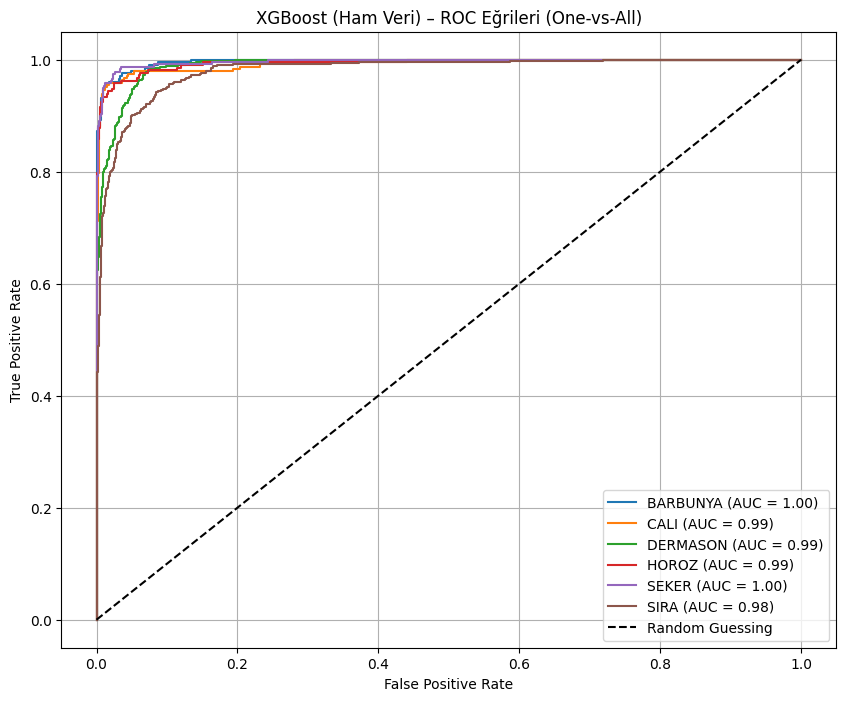

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

# Etiketleri One-vs-All için binary hale getirelim
y_binarized = label_binarize(y_base, classes=np.unique(y_base))
n_classes = y_binarized.shape[1]

# Eğitim-test bölmesi (tek seferlik ROC için)
X_train, X_test, y_train, y_test = train_test_split(X_base, y_binarized, test_size=0.3, random_state=42, stratify=y_base)

# One-vs-Rest sınıflandırıcı ile XGBoost modeli
xgb_roc = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42,
                        n_estimators=100, max_depth=6, learning_rate=0.1)
clf = OneVsRestClassifier(xgb_roc)
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)

# ROC eğrileri ve AUC hesaplama
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC eğrilerini çiz
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    class_name = le.inverse_transform([i])[0]
    plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost (Ham Veri) – ROC Eğrileri (One-vs-All)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## ROC AUC Skorları (XGBoost – Ham Veri)

### 🔍 ROC AUC Skorları (XGBoost – Ham Veri)

| Sınıf     | AUC Skoru |
|-----------|------------|
| BARBUNYA  | 1.00       |
| CALI      | 0.99       |
| DERMASON  | 0.99       |
| HOROZ     | 0.99       |
| SEKER     | 1.00       |
| SIRA      | 0.98       |


XGBoost modeli, sınıfları çok yüksek doğrulukla ayırt edebiliyor.

ROC eğrileri neredeyse ideal → Bu modeli “en başarılı temsil” olarak raporda açıkça belirt.